In [3]:
import pandas as pd
import streamlit as st
import sqlite3
import matplotlib.pyplot as plt
import altair as alt

### Conexão com o banco de dados

In [1]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df


### Funções Auxiliares

In [24]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

In [5]:
df = getLvl1Data()

In [6]:
print(df.columns)

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population'],
      dtype='object')


In [25]:
br_confirmed = get_feature_time_series_lvl_1(df, feature='confirmed', administrative_area_level_1='Brazil')

In [26]:
br_confirmed

,confirmed
date,
2020-02-25,1.0
2020-02-26,1.0
2020-02-27,1.0
2020-02-28,2.0
2020-02-29,2.0
...,...
2023-03-19,37085520.0
2023-03-20,37085520.0
2023-03-21,37085520.0


In [11]:
plt.rc('axes', titlesize='medium')
plt.rc('axes', titlelocation='left')
plt.rc('axes.spines', right=False)
plt.rc('axes.spines', top=False)
sizets = (8,6)
plt.rc('figure', figsize=sizets)

In [12]:
def plot_time_series(df:pd.DataFrame):
    
    feature = df.columns[0].title()

    ax = df.iloc[:,0].plot(figsize=sizets)
    plt.suptitle('Cumulative Confirmed')
    ax.set(ylabel=f'{feature}', title='Test')
    ax.grid() 

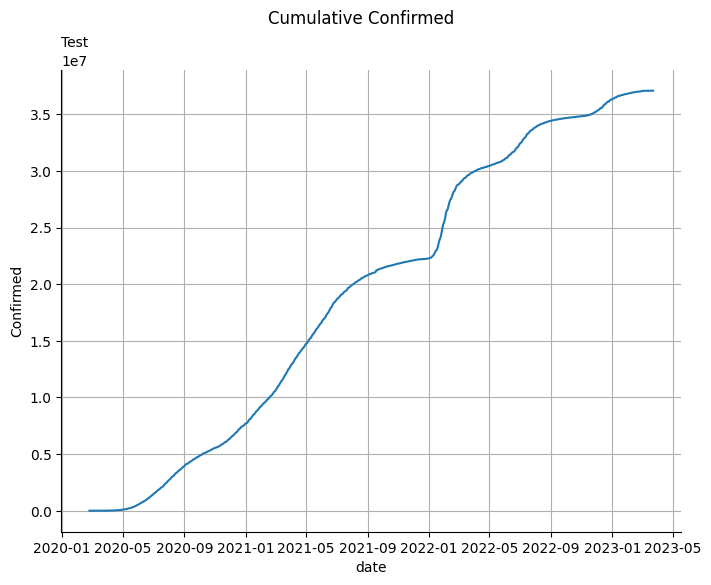

In [13]:
plot_time_series(br_confirmed)

### Plotting the Data with Altair

In [38]:
test_df = br_confirmed.reset_index()
test_df.melt(id_vars='date')

,date,variable,value
0,2020-02-25,confirmed,1.0
1,2020-02-26,confirmed,1.0
2,2020-02-27,confirmed,1.0
3,2020-02-28,confirmed,2.0
4,2020-02-29,confirmed,2.0
...,...,...,...
1118,2023-03-19,confirmed,37085520.0
1119,2023-03-20,confirmed,37085520.0
1120,2023-03-21,confirmed,37085520.0
1121,2023-03-22,confirmed,37085520.0


In [40]:
alt.Chart(data=br_confirmed.reset_index().melt(id_vars='date')).mark_line().encode(
    x = 'date:T', 
    y = 'value:Q'
).properties(
    width=800, 
    height=400
)

alt.Chart(...)